## **Taller 1**

Empleando la información del **número de ocupados** en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses. Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.

## Carga de librerías

In [364]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error

In [365]:
# Configuración de gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo general (usa seaborn con fondo limpio)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('talk', font_scale=1.2)

# Configuración global de Matplotlib
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'axes.titlesize': 18,
    'axes.titleweight': 'bold',
    'axes.titlepad': 15,
    'axes.labelsize': 13,
    'axes.labelcolor': 'black',
    'axes.edgecolor': 'gray',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.color': '#cccccc',
    'lines.linewidth': 2,  # grosor de las líneas
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans'],
    'legend.frameon': False,
    'legend.fontsize': 12,
    'legend.loc': 'upper right',
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'xtick.color': 'black',
    'ytick.color': 'black',
    'axes.prop_cycle': plt.cycler(color=[
        '#007acc', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'
    ])  # paleta de colores corporativa
})

# Tema de seaborn adicional
sns.set_style("whitegrid")



In [366]:
data = pd.read_excel("datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.info()
print(data.head())
print(data.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 222 entries, 2001-01-01 to 2019-06-01
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TD_13ciudades  222 non-null    float64
 1   Ocupados       222 non-null    float64
 2   Desocupados    222 non-null    float64
 3   Inactivos      222 non-null    float64
dtypes: float64(4)
memory usage: 8.7 KB
            TD_13ciudades  Ocupados  Desocupados  Inactivos
mes                                                        
2001-01-01      20.946380  6923.604     1834.507   4600.718
2001-02-01      19.894213  7037.746     1747.820   4596.805
2001-03-01      19.221565  6945.973     1652.823   4807.120
2001-04-01      17.888575  6973.079     1519.137   4937.280
2001-05-01      17.945654  6994.462     1529.720   4928.911
            TD_13ciudades   Ocupados  Desocupados  Inactivos
mes                                                         
2019-02-01      12.427409  1055

In [367]:
data.describe()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
count,222.000000,222.000000,222.000000,222.000000
mean,12.601883,9160.852009,1290.681131,5500.277973
std,2.808235,1295.492800,181.948810,389.227213
min,8.140713,6923.604000,857.491000,4596.805000
25%,10.396078,7971.103000,1152.874750,5308.814750
50%,11.925036,9139.064500,1270.201000,5533.044500
75%,14.087588,10458.510250,1398.899250,5752.608500
max,20.946380,11037.199000,1834.507000,6395.575000


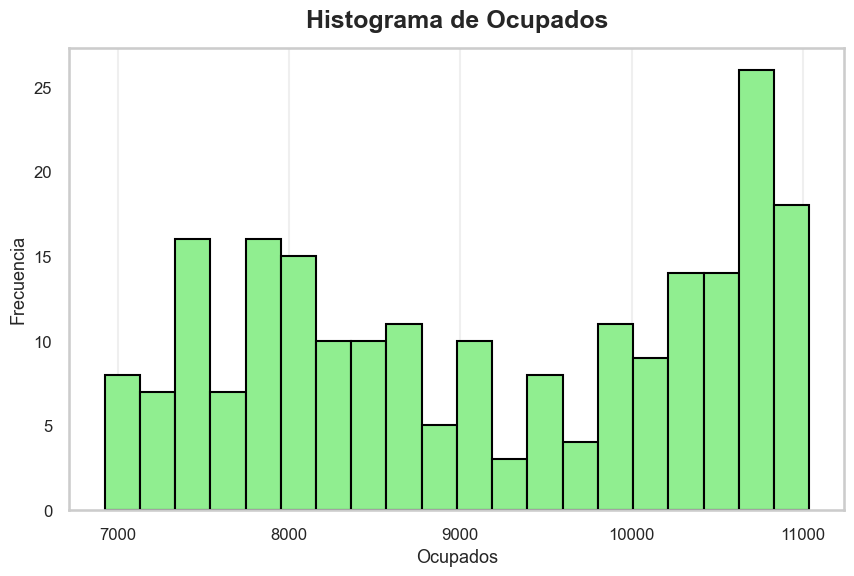

In [368]:
plt.figure(figsize=(10, 6))
plt.hist(data["Ocupados"], bins=20, color='lightgreen', edgecolor='black')
plt.title("Histograma de Ocupados")
plt.xlabel("Ocupados")
plt.ylabel("Frecuencia")
plt.grid(axis='y')
plt.show()

(222, 4)


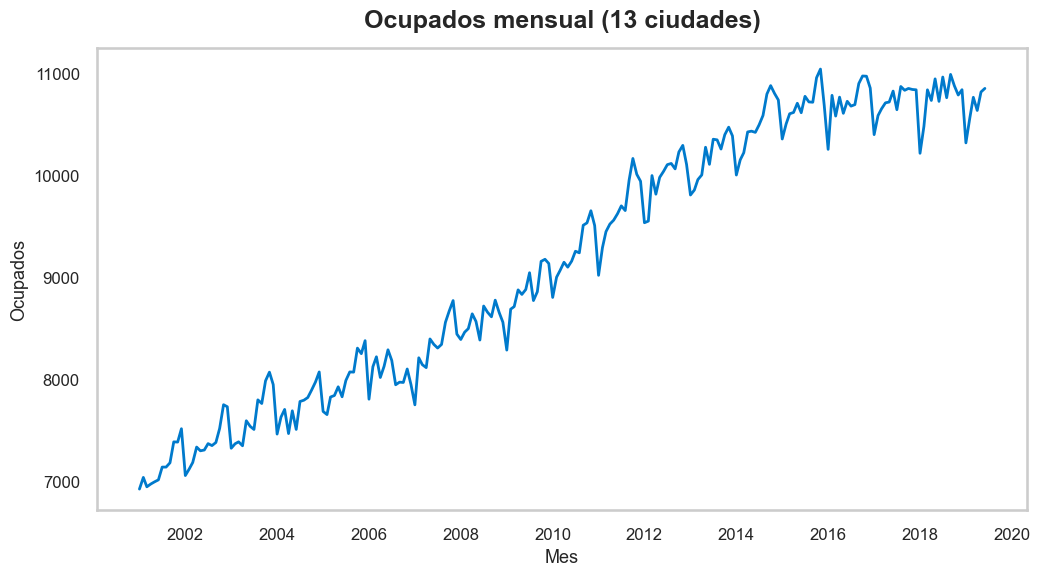

In [369]:
# Tamaño del dataframe
print(data.shape)

# Graficar los datos
plt.title("Ocupados mensual (13 ciudades)")
plt.xlabel("Mes")
plt.ylabel("Ocupados")
plt.plot(data[["Ocupados"]])
plt.grid()
plt.show()

Se descomponen los datos en sus componentes estacionales, se probó con el modelo multiplicativo pero el ruido se fue a positivo todo, por lo que consideramos que no es el modelo adecuado, debería ser aditivo, con lo que mejora el ruido.

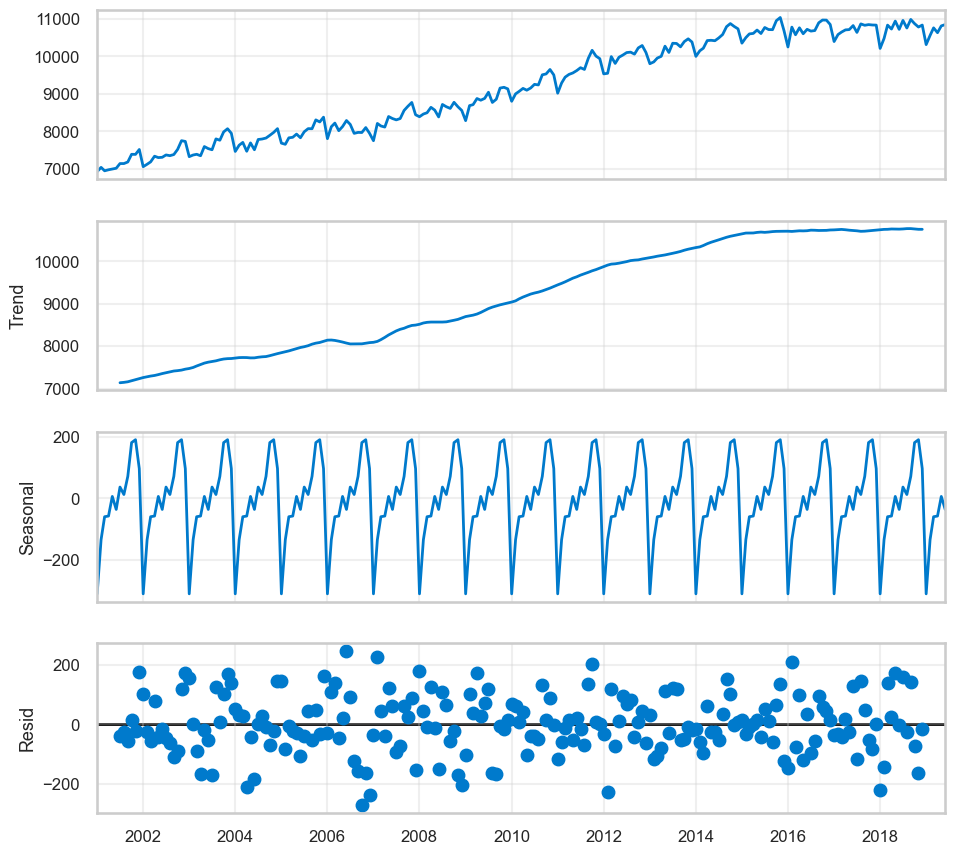

In [370]:
td_componentes = seasonal_decompose(data[["Ocupados"]],model="aditive")
fig = td_componentes.plot()
fig.set_size_inches((10, 9))
fig.tight_layout()
plt.show()

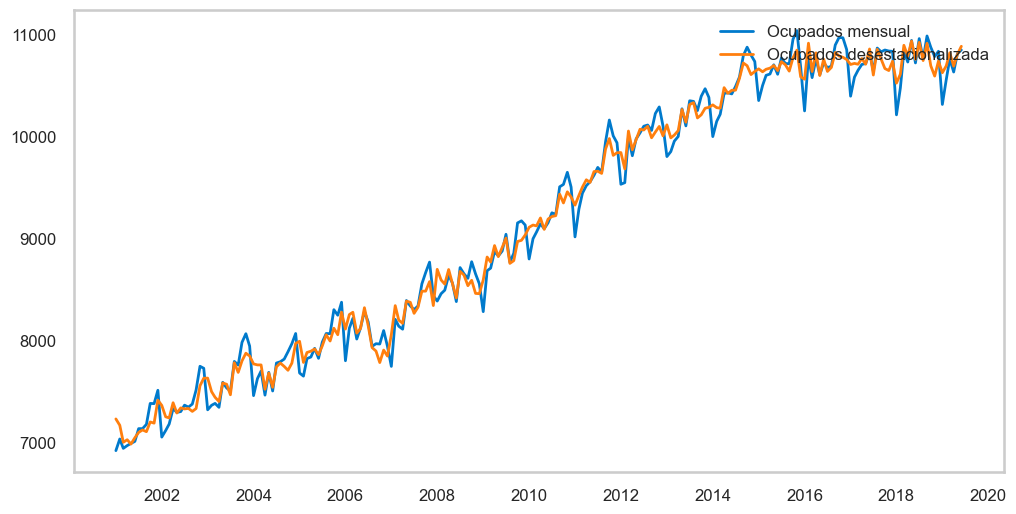

In [371]:
td_desestacionalizada = data["Ocupados"]-td_componentes.seasonal

plt.plot(data[["Ocupados"]],label="Ocupados mensual")
plt.plot(td_desestacionalizada,label="Ocupados desestacionalizada")
plt.legend()
plt.grid()
plt.show()

## **Pronóstico**

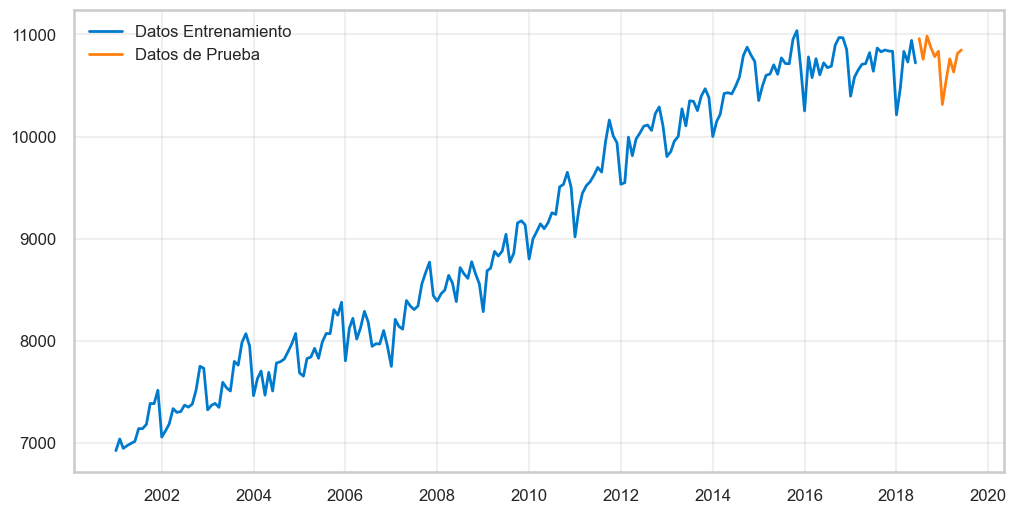

In [372]:
#Dividir los conjuntos de prueba y entrenamiento

train_len = 210
train_td = data[["Ocupados"]][:train_len]
test_td = data[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(test_td,label="Datos de Prueba")
plt.legend(loc="upper left")
plt.show()

In [373]:
## Considerando el dato actual porque estan completos los datos
ma_2= train_td.rolling(2,min_periods=2).mean()
ma_3= train_td.rolling(3,min_periods=2).mean()
ma_4= train_td.rolling(4,min_periods=2).mean()
ma_5= train_td.rolling(5,min_periods=2).mean()
ma_6= train_td.rolling(6,min_periods=2).mean()

In [374]:
def fore_ma(datos,w,h):
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:]

In [375]:
ma_2_f= fore_ma(train_td,2,12)
ma_3_f= fore_ma(train_td,3,12)
ma_4_f= fore_ma(train_td,4,12)
ma_5_f= fore_ma(train_td,5,12)
ma_6_f= fore_ma(train_td,6,12)

In [376]:
rmse_ma_2 = np.sqrt(mean_squared_error(test_td,ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(test_td,ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(test_td,ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(test_td,ma_5_f ))
rmse_ma_6 = np.sqrt(mean_squared_error(test_td,ma_6_f ))

In [377]:
print(f"Raiz del error cuadrático medio con 2 periodos: {rmse_ma_2}")
print(f"Raiz del error cuadrático medio con 3 periodos: {rmse_ma_3}")
print(f"Raiz del error cuadrático medio con 4 periodos: {rmse_ma_4}")
print(f"Raiz del error cuadrático medio con 5 periodos: {rmse_ma_5}")
print(f"Raiz del error cuadrático medio con 6 periodos: {rmse_ma_6}")

Raiz del error cuadrático medio con 2 periodos: 177.050156075185
Raiz del error cuadrático medio con 3 periodos: 182.79913922989712
Raiz del error cuadrático medio con 4 periodos: 180.29590256191878
Raiz del error cuadrático medio con 5 periodos: 181.77806833006787
Raiz del error cuadrático medio con 6 periodos: 184.10666512824392


Se elige entonces el modelo con 2 periodos por ser el que tiene el valor más bajo para la grafica

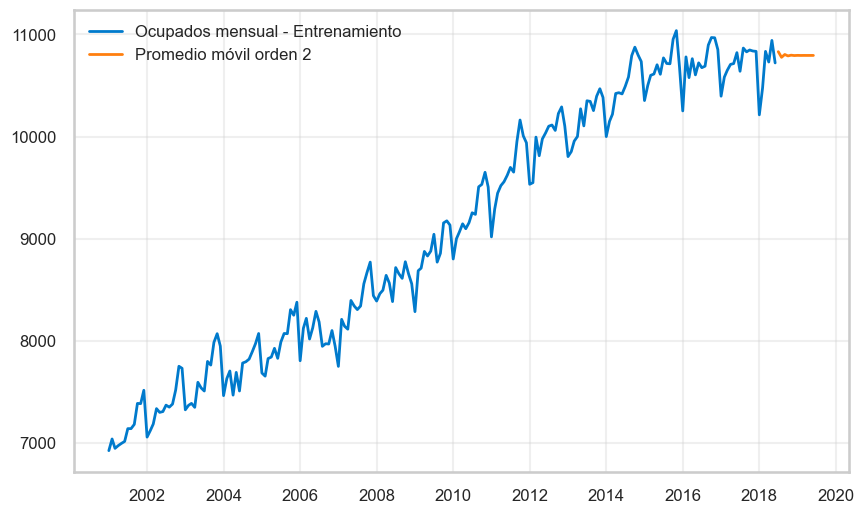

In [378]:
fig = plt.figure(figsize=(10, 6))
plt.plot(train_td,label="Ocupados mensual - Entrenamiento")
plt.plot(ma_2_f,label="Promedio móvil orden 2")
plt.legend(loc='upper left')
plt.show()

### **Suavizacion Exponencial Simple**

In [379]:
# Build model.
ets_model = ETSModel(endog=train_td["Ocupados"],error="add",trend="add",seasonal="add",seasonal_periods=12 )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis = 1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

c:\Users\ALEXANDER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-07-01    10868.306798  10647.320444  11089.293152
2018-08-01    10874.404757  10626.875983  11121.933531
2018-09-01    10940.418284  10668.925179  11211.911388
2018-10-01    11080.945802  10787.434294  11374.457310
2018-11-01    11114.282781  10800.289164  11428.276399
2018-12-01    11028.121614  10694.898766  11361.344462
2019-01-01    10647.724207  10296.319271  10999.129142
2019-02-01    10839.097873  10470.403040  11207.792705
2019-03-01    10920.657876  10535.445183  11305.870569
2019-04-01    10939.013554  10537.959634  11340.067473
2019-05-01    11016.657906  10600.362142  11432.953670
2019-06-01    10993.161868  10562.160048  11424.163689


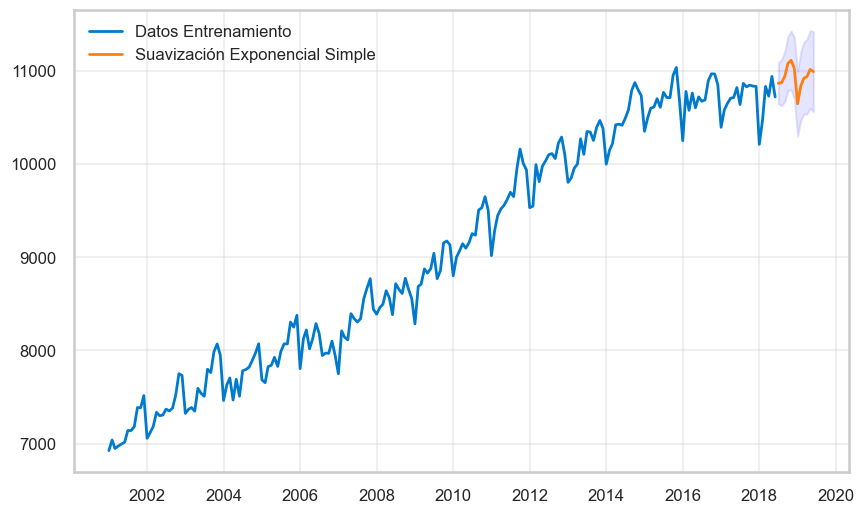

In [380]:
fig = plt.figure(figsize=(10, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend(loc="upper left")
plt.show()

<Axes: title={'center': 'Residuos del modelo ETS'}, xlabel='mes'>

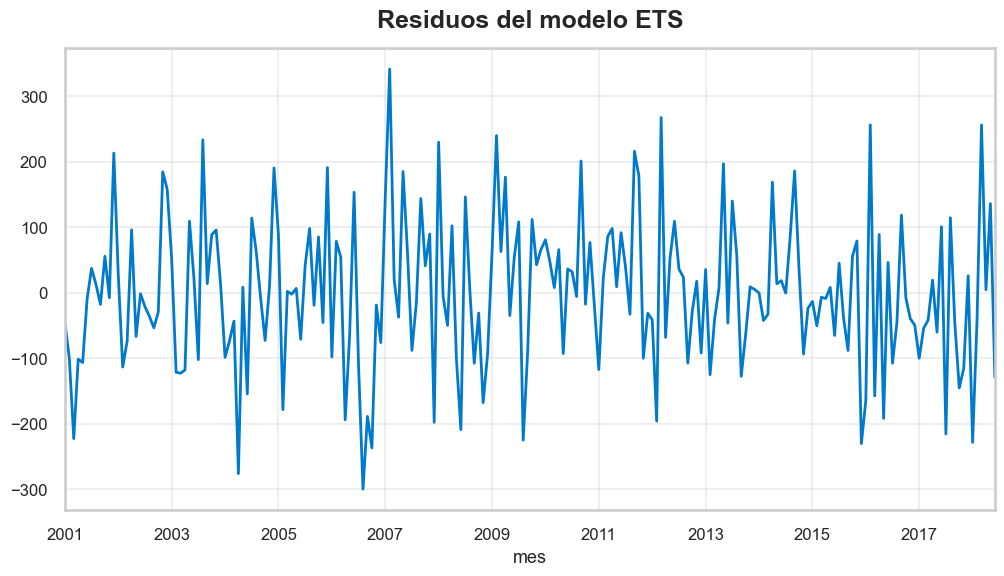

In [381]:
ets_result.resid.plot(title="Residuos del modelo ETS")

In [382]:
ets_result.alpha
rmse = np.sqrt(mean_squared_error(test_td[:12],point_forecast ))
print(f"ETS Alpha: {ets_result.alpha:.2f}")
print(f"RMSE: {rmse:.2f}")

ETS Alpha: 0.50
RMSE: 220.97


### **Suavizacion Exponencial Lineal (Holt)**

In [383]:
# Build model.
ets_model = ETSModel(endog=train_td["Ocupados"],error="mul",trend="mul")#,seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_holt = pd.concat([limits, conf_forecast], axis = 1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_holt)

            Point_forecast      lower_95      upper_95
2018-07-01    10815.324614  10399.665804  11232.558885
2018-08-01    10839.229828  10373.471906  11304.981903
2018-09-01    10863.187881  10346.631228  11381.022831
2018-10-01    10887.198887  10303.232363  11475.074457
2018-11-01    10911.262966  10300.513344  11482.933822
2018-12-01    10935.380234  10298.477741  11607.864310
2019-01-01    10959.550808  10267.245134  11682.741196
2019-02-01    10983.774807  10195.231763  11731.611639
2019-03-01    11008.052348  10227.310029  11751.692574
2019-04-01    11032.383550  10191.097582  11831.614674
2019-05-01    11056.768532  10294.830788  11926.341831
2019-06-01    11081.207411  10271.867542  11945.716927


c:\Users\ALEXANDER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


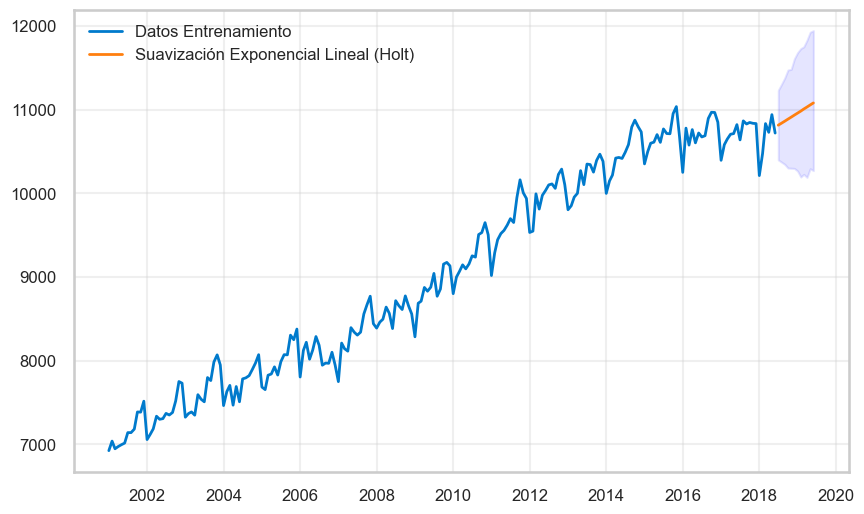

In [384]:
fig = plt.figure(figsize=(10, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_holt['Point_forecast'],label="Suavización Exponencial Lineal (Holt)")
plt.fill_between(preds_holt.index ,preds_holt['lower_95'], preds_holt['upper_95'], color='blue', alpha=0.1)
plt.legend(loc="upper left")
plt.show()

In [385]:
rmse_holt = np.sqrt(mean_squared_error(test_td[:12],preds_holt['Point_forecast']))
print(f"Alpha: {ets_result.alpha}, Beta: {ets_result.beta}")
print(f"RMSE Holt: {rmse_holt}")

Alpha: 0.5577163897422279, Beta: 5.5771638974222795e-05
RMSE Holt: 288.9086575572236


## **Suavizacion Exponencial Lineal de Winters (Holt-Winters)**

In [386]:
# Build model
ets_model = ETSModel(endog=train_td["Ocupados"],error="add",trend="add",seasonal="add" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

c:\Users\ALEXANDER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-07-01    10868.306798  10647.320444  11089.293152
2018-08-01    10874.404757  10626.875983  11121.933531
2018-09-01    10940.418284  10668.925179  11211.911388
2018-10-01    11080.945802  10787.434294  11374.457310
2018-11-01    11114.282781  10800.289164  11428.276399
2018-12-01    11028.121614  10694.898766  11361.344462
2019-01-01    10647.724207  10296.319271  10999.129142
2019-02-01    10839.097873  10470.403040  11207.792705
2019-03-01    10920.657876  10535.445183  11305.870569
2019-04-01    10939.013554  10537.959634  11340.067473
2019-05-01    11016.657906  10600.362142  11432.953670
2019-06-01    10993.161868  10562.160048  11424.163689


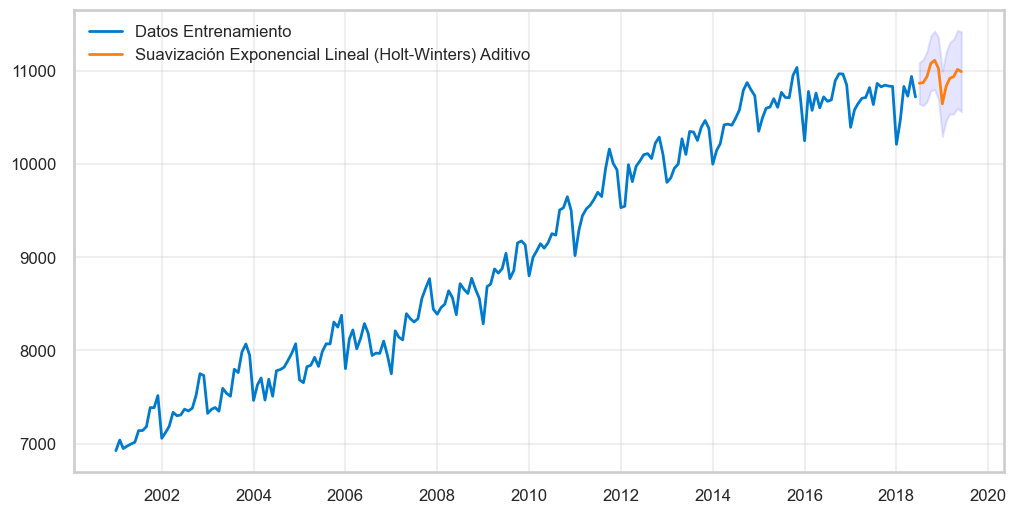

In [387]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend(loc="upper left")
plt.show()

In [388]:
rmse_hw_add = np.sqrt(mean_squared_error(test_td[:12],preds_hw_add['Point_forecast']))
print(f"RMSE Holt-Winters Aditivo: {rmse_hw_add:.2f}")
print(f"Alpha: {ets_result.alpha:.2f}, Beta: {ets_result.beta}, Gamma: {ets_result.gamma:.2f}")

RMSE Holt-Winters Aditivo: 220.97
Alpha: 0.50, Beta: 5.045720375796844e-05, Gamma: 0.00


In [389]:
# Build model.
ets_model = ETSModel(endog=train_td["Ocupados"],error="add",trend=None,seasonal="mul" , )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_mul)

            Point_forecast      lower_95      upper_95
2018-07-01    10846.757433  10617.201928  11081.814720
2018-08-01    10831.088020  10558.805730  11093.488555
2018-09-01    10893.100718  10580.922655  11182.673470
2018-10-01    11036.428714  10693.922417  11368.926301
2018-11-01    11051.205112  10696.846075  11429.211771
2018-12-01    10924.837087  10528.389186  11289.794637
2019-01-01    10448.091150  10030.657430  10838.369618
2019-02-01    10651.796635  10252.645323  11080.381756
2019-03-01    10735.511758  10333.365770  11149.161075
2019-04-01    10744.414152  10298.814011  11178.517027
2019-05-01    10813.080852  10338.117956  11294.299032
2019-06-01    10767.773025  10294.604916  11248.044677


c:\Users\ALEXANDER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


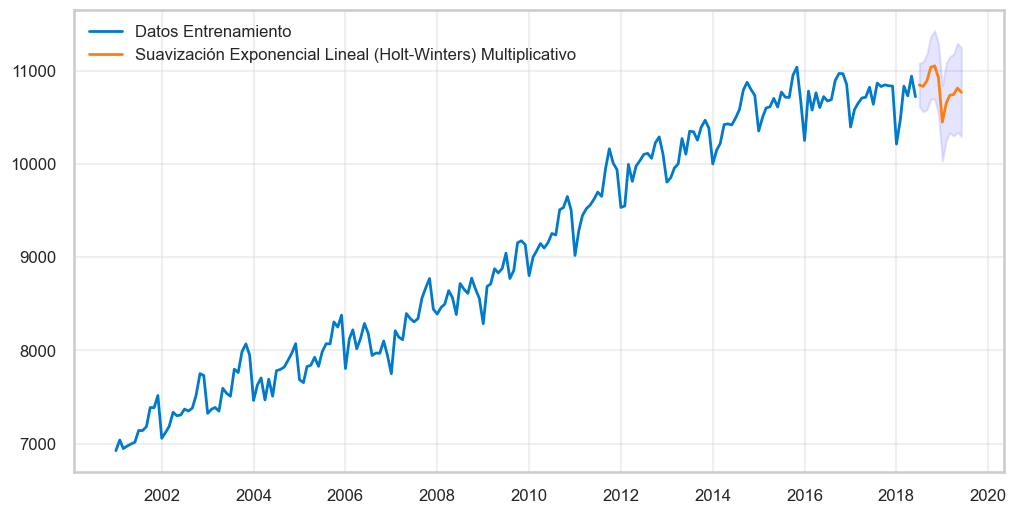

In [390]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_hw_mul['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Multiplicativo")
plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
plt.legend(loc="upper left")
plt.show()

In [391]:
rmse_hw_mul = np.sqrt(mean_squared_error(test_td[:12], preds_hw_mul['Point_forecast']))
print(f"RMSE Holt-Winters Multiplicativo: {rmse_hw_mul:.2f}")
print(f"Alpha: {ets_result.alpha:.2f}, Gamma: {ets_result.gamma}")

RMSE Holt-Winters Multiplicativo: 122.14
Alpha: 0.61, Gamma: 3.9498654951828164e-05


## **Predicción 6 meses próximos** ##

Dado que el modelo que mejor resultado obtuvo para los datos fue el suavización exponencial holt winters multiplicativo, ese se eligió como el adecuado para la proyección de los seis meses siguiente.

In [392]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 222 entries, 2001-01-01 to 2019-06-01
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TD_13ciudades  222 non-null    float64
 1   Ocupados       222 non-null    float64
 2   Desocupados    222 non-null    float64
 3   Inactivos      222 non-null    float64
dtypes: float64(4)
memory usage: 8.7 KB


In [397]:
# Build model.
ets_model = ETSModel(endog=data["Ocupados"],error="add",trend=None,seasonal="mul" , )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(6)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_mul)

            Point_forecast      lower_95      upper_95
2019-07-01    10890.476734  10668.869447  11117.439937
2019-08-01    10860.094959  10597.720712  11124.142497
2019-09-01    10934.972152  10637.767115  11228.798858
2019-10-01    11059.017257  10727.409499  11384.321004
2019-11-01    11065.791357  10700.112401  11458.291009
2019-12-01    10952.267361  10564.142674  11366.109691


c:\Users\ALEXANDER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


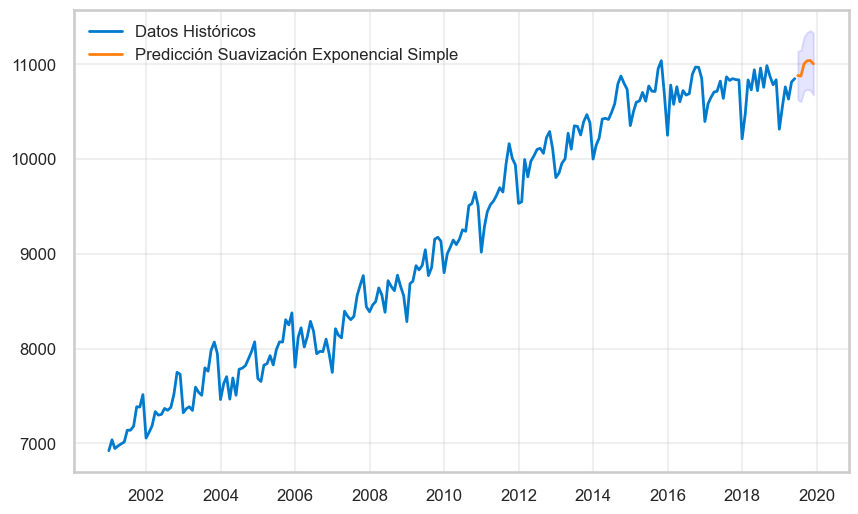

In [396]:
fig = plt.figure(figsize=(10, 6))
plt.plot(data["Ocupados"],label="Datos Históricos")
plt.plot(preds['Point_forecast'],label="Predicción Suavización Exponencial Simple")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend(loc="upper left")
plt.show()